# `WDM` on zf

# running `WDM` on zf

## imports

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
!pip install scanpy -q

In [68]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [69]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [70]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [72]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [73]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]


Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks

In [74]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]
# exclude_rows = [1099, None, None, 325, None, None]

## load features and spatial coords specific to the triple

In [75]:
s0_name = zf_names[0]
s1_name = zf_names[1]
s2_name = zf_names[2]
s3_name = zf_names[3]
s4_name = zf_names[4]
s5_name = zf_names[5]


filehandle_pair0 = filehandle_zf + 'pair' + str(0) + '/'
filehandle_pair1 = filehandle_zf + 'pair' + str(1) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(2) + '/'
filehandle_pair3 = filehandle_zf + 'pair' + str(3) + '/'
filehandle_pair4 = filehandle_zf + 'pair' + str(4) + '/'


X0 = np.load(filehandle_pair0 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair3 + s3_name + '_feature.npy')
X4 = np.load(filehandle_pair4 + s4_name + '_feature.npy')
X5 = np.load(filehandle_pair4 + s5_name + '_feature.npy')

Xs = [X0, X1, X2, X3, X4, X5]

## form cost matrices

In [76]:
C12_np = cdist(X1, X2)
C23_np = cdist(X2, X3)

'''
A11_np = cdist(S1, S1)
A22_np = cdist(S2, S2)
A33_np = cdist(S3, S3)
''';

In [77]:
C12 = torch.from_numpy(C12_np).to(device)
C23 = torch.from_numpy(C23_np).to(device)

'''
A11 = torch.from_numpy(A11_np).to(device)
A22 = torch.from_numpy(A22_np).to(device)
A33 = torch.from_numpy(A33_np).to(device)
''';

## alternate idea for cost matrices

In [78]:
# code now in util_zf.py
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

## set truncation, time

In [79]:
## set truncation
truncation = 50
time = 10.0

## make HDM representation of each slice

## overriding old cost matrices

In [80]:
%%time
Aiis_np = []

for i, X in enumerate(Xs):
    X_HDM = util_zf.HDM_from_XS(spatial_list[i], X, truncation=truncation, time=time)
    Aii_HDM_np = cdist(X_HDM, X_HDM)
    Aiis_np += [Aii_HDM_np]


Aiis = [torch.from_numpy(Aii).to(device) for Aii in Aiis_np]

CPU times: user 3min 11s, sys: 2min 16s, total: 5min 27s
Wall time: 36.1 s


## set ranks, excluded rows for triple

In [81]:
len(Aiis)

6

In [82]:
'''
r1, r2 = ranks[i]
r2, r3 = ranks[i+1]
nidx_1, nidx_2, nidx_3 = exclude_rows[i], exclude_rows[i+1], exclude_rows[i+2]
''';

## factor cost matrices

In [83]:
importlib.reload(util_zf)


<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [84]:
rank_list = [(3,7),(7,7),(7,11),(11,14),(14,19)]
#exclude_rows = [1099, None, None, 325, None, None]

C_factors_sequence = []
A_factors_sequence = []

for i in range(len(rank_list)):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Loading slices {s1_name} to {s2_name}')

    r1, r2 = rank_list[i]
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]

    filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
    save_dir = filehandle_pair
    C_matrix = cdist(Xs[i], Xs[i+1])
    C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C_matrix, Aiis[i].cpu().numpy(), Aiis[i+1].cpu().numpy(), \
                                                    device, z=50, c=100, nidx_1=nidx_1, nidx_2=nidx_2)
    C_factors_sequence.append(C_factors12)
    if i == 0:
        A_factors_sequence.append(A_factors11)
        A_factors_sequence.append(A_factors22)
    else:
        A_factors_sequence.append(A_factors22)




c = max([torch.max(C[0] @ C[1]) for C in C_factors_sequence])
c = max(c, 1/c)
for i in range(len(C_factors_sequence)):
    C = C_factors_sequence[i]
    C_factors_sequence[i] = (C[0]/c, C[1]/c)

Loading slices zf3 to zf5
C done
A done
B done
Loading slices zf5 to zf10
C done
A done
B done
Loading slices zf10 to zf12
C done
A done
B done
Loading slices zf12 to zf18
C done
A done
B done
Loading slices zf18 to zf24
C done
A done
B done


## set OT hyperparameters

In [85]:
gamma=500
tau_out=1e1
tau_in=1e-7
alpha = 0.1
beta = 0.0

max_iter=100
min_iter=100

## run `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.939657848142831e-09, GW-cost: 3.791027553068942e-39, Total cost: 3.545692063328548e-09
Final Wasserstein cost: 3.6100604024256765e-09, GW-cost: 3.8040733285452604e-39, Total cost: 3.2490543621831088e-09


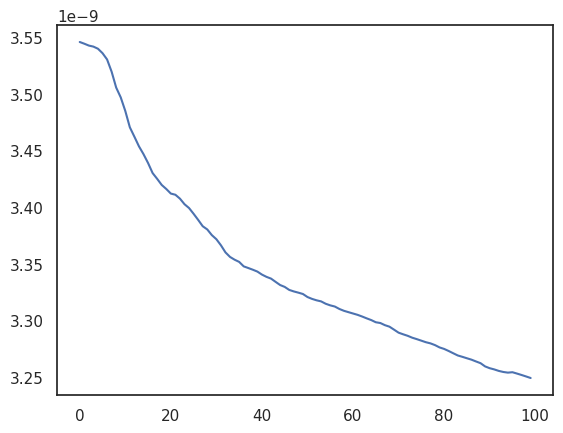

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 4.147777637222815e-09, GW-cost: 3.80406722967593e-39, Total cost: 3.732999873500534e-09
Final Wasserstein cost: 3.928842785144245e-09, GW-cost: 3.804066868924948e-39, Total cost: 3.5359585066298206e-09


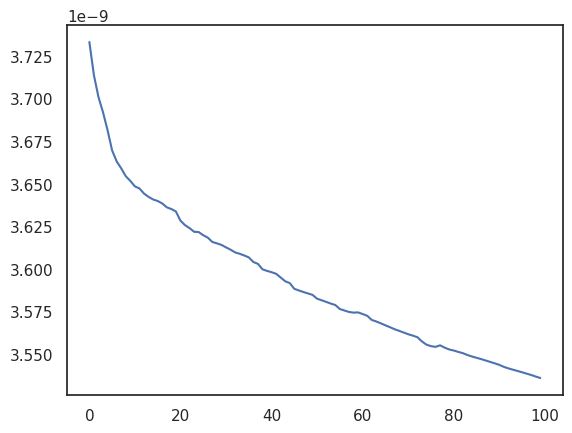

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.7961962016996625e-09, GW-cost: 1.8095181117293824e-50, Total cost: 2.5165765815296965e-09
Final Wasserstein cost: 2.584710463574932e-09, GW-cost: 1.809518111729181e-50, Total cost: 2.326239417217439e-09


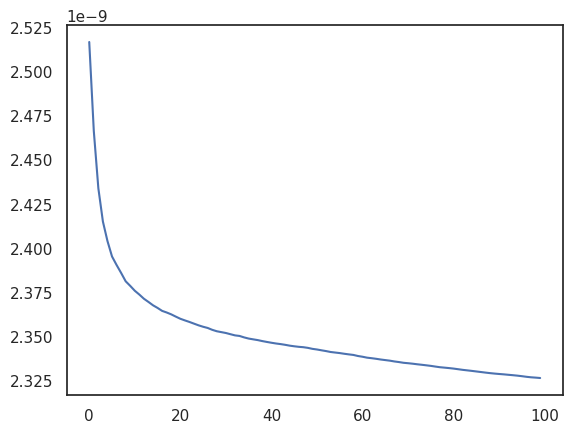

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.0856359676854954e-09, GW-cost: 9.175230640445573e-73, Total cost: 2.777072370916946e-09
Final Wasserstein cost: 2.8196923362901635e-09, GW-cost: 9.171826639936048e-73, Total cost: 2.537723102661147e-09


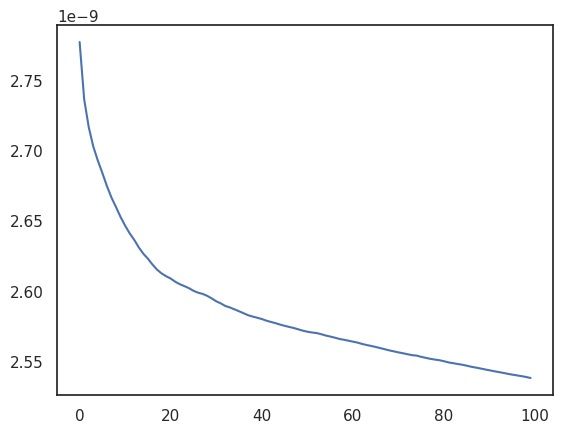

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.4364536166203427e-09, GW-cost: 8.406974303220443e-74, Total cost: 3.0928082549583084e-09
Final Wasserstein cost: 2.6122761079319714e-09, GW-cost: 8.821078997147528e-74, Total cost: 2.3510484971387744e-09


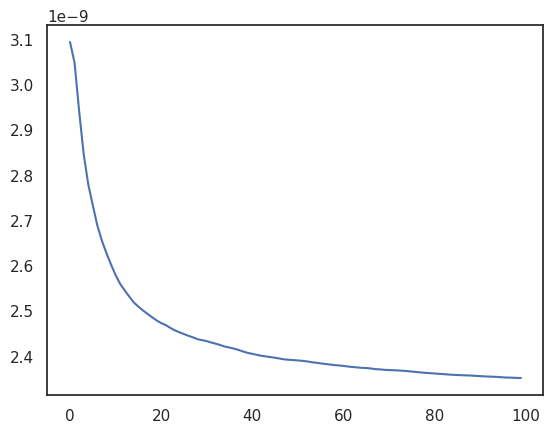

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.1429921196577483e-09, GW-cost: 8.65546944913172e-73, Total cost: 2.8286929076919734e-09
Final Wasserstein cost: 2.7970084105806446e-09, GW-cost: 8.257761605761513e-73, Total cost: 2.5173075695225803e-09


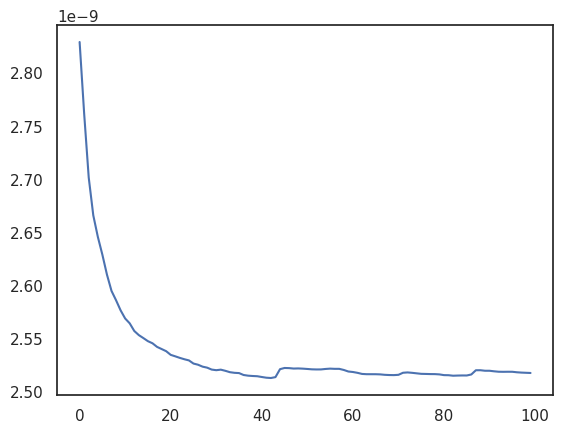

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.6453741834481524e-09, GW-cost: 1.6652240412642989e-50, Total cost: 2.3808367651033374e-09
Final Wasserstein cost: 2.4163602982859654e-09, GW-cost: 1.8536001067759112e-50, Total cost: 2.174724268457369e-09


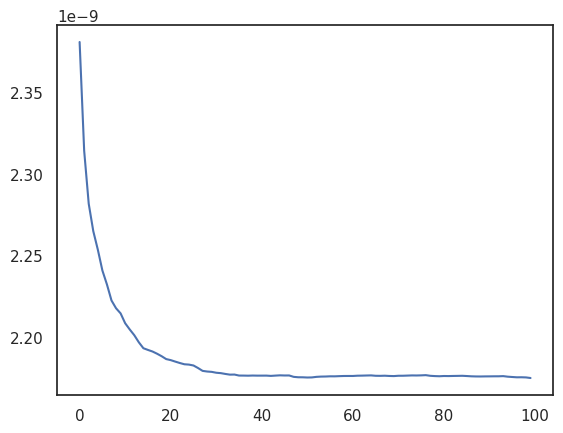

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.923723950868586e-09, GW-cost: 3.7448686635469803e-39, Total cost: 3.5313515557817273e-09
Final Wasserstein cost: 3.802215328626049e-09, GW-cost: 3.262446589978871e-39, Total cost: 3.4219937957634444e-09


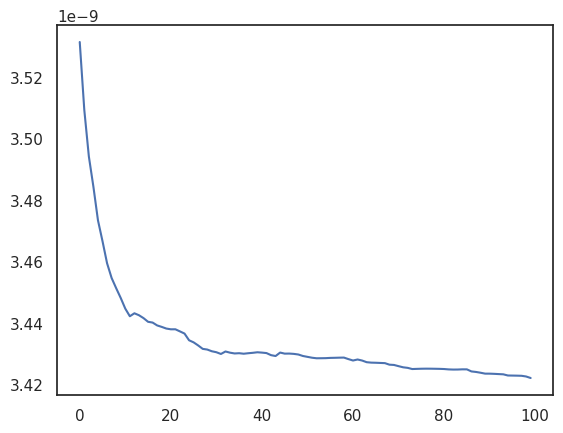

Ranks: r1 3, r2 7, r3 7
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 7.846437740409161e-09
Final Wasserstein-sum cost: 7.630046797511557e-09


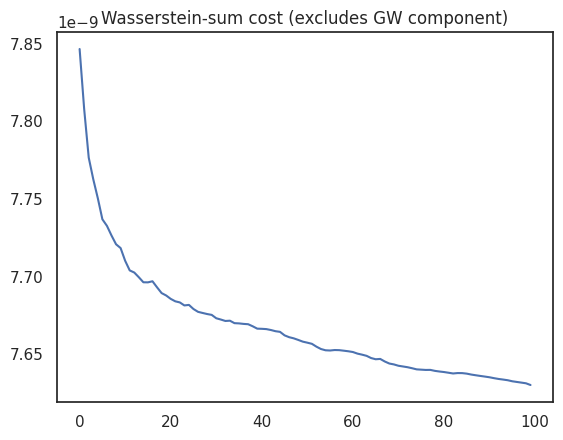

Ranks: r1 7, r2 7, r3 11
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.843247700295057e-09
Final Wasserstein-sum cost: 6.383778382435456e-09


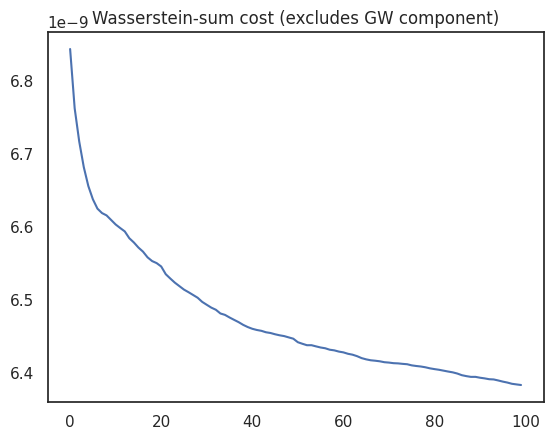

Ranks: r1 7, r2 11, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.030443301699002e-09
Final Wasserstein-sum cost: 5.369749880450232e-09


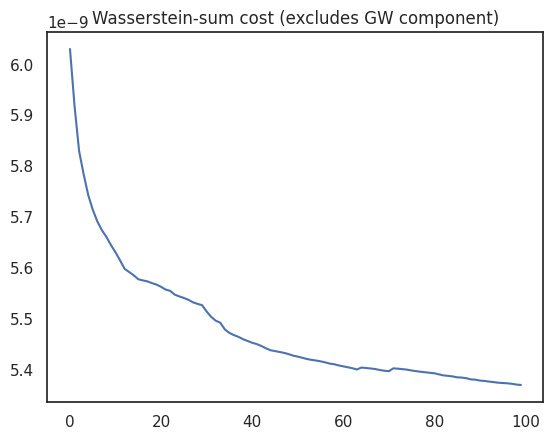

Ranks: r1 11, r2 14, r3 19
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.17891895793832e-09
Final Wasserstein-sum cost: 5.592766632793695e-09


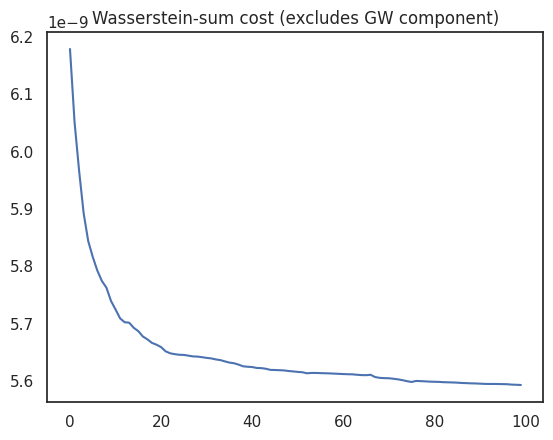

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.835483540927116e-09, GW-cost: 3.560592829041465e-39, Total cost: 3.4519351868344045e-09
Final Wasserstein cost: 3.7651715088488095e-09, GW-cost: 3.5605928290414655e-39, Total cost: 3.3886543579639287e-09


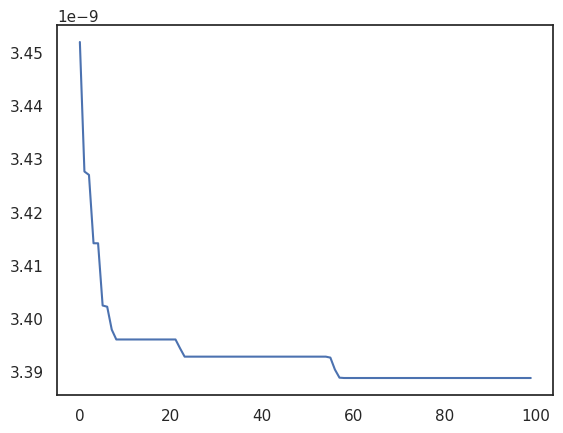

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.85240364932638e-09, GW-cost: 3.560586548332314e-39, Total cost: 3.467163284393742e-09
Final Wasserstein cost: 3.806681572199849e-09, GW-cost: 3.5605865649285966e-39, Total cost: 3.4260134149798646e-09


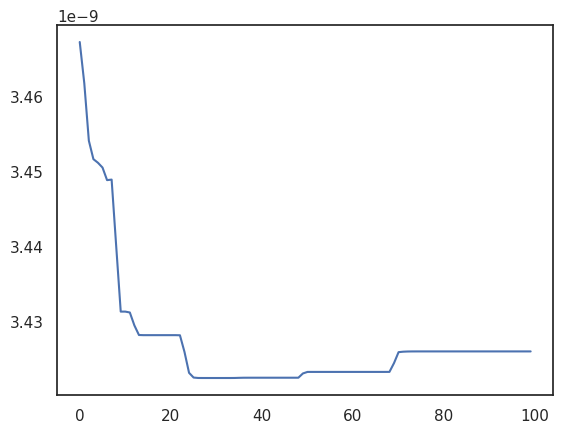

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.6374863681525706e-09, GW-cost: 1.895854299590418e-50, Total cost: 2.3737377313373138e-09
Final Wasserstein cost: 2.442167841303849e-09, GW-cost: 1.895854299590925e-50, Total cost: 2.1979510571734643e-09


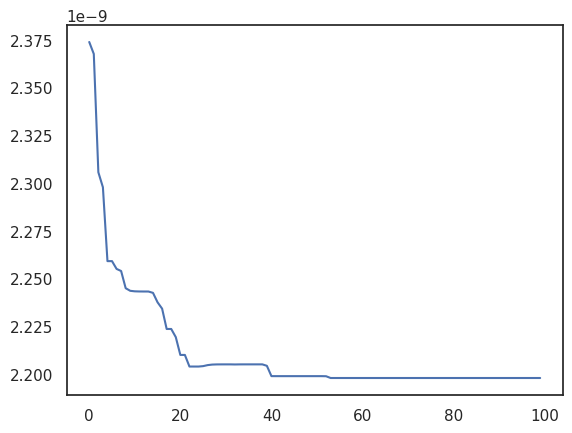

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.043812315801248e-09, GW-cost: 8.360793308335235e-73, Total cost: 2.739431084221123e-09
Final Wasserstein cost: 2.845983751279862e-09, GW-cost: 8.723363909542411e-73, Total cost: 2.5613853761518756e-09


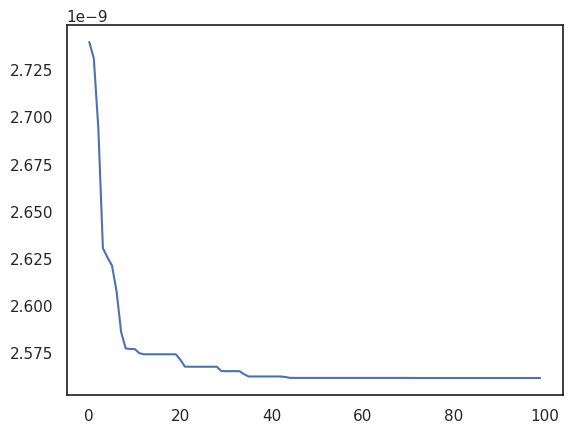

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.948810751573513e-09, GW-cost: 8.85831652344874e-74, Total cost: 2.653929676416162e-09
Final Wasserstein cost: 2.669430902283402e-09, GW-cost: 8.858316505767535e-74, Total cost: 2.402487812055062e-09


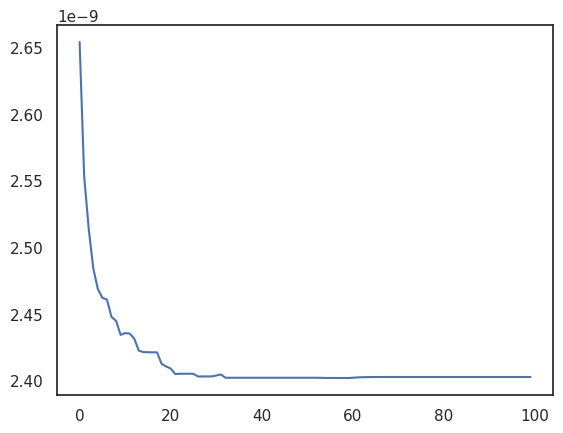

CPU times: user 5min 19s, sys: 3.92 s, total: 5min 23s
Wall time: 5min 18s


In [86]:
%%time
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(rank_list, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

Qs_pred = [Q.cpu().numpy() for Q in WDM.Q_gammas]
Ts_pred = [T.cpu().numpy() for T in WDM.T_gammas]

In [87]:
Ss = spatial_list

node_labels1 = [None for Q in WDM.Q_gammas]

clustering.plot_clusters_from_QT(Ss, Qs_pred, Ts_ann, node_labels1)
clustering.diffmap_from_QT(Qs_pred, Ts_pred, cell_type_labels=node_labels1)

Output hidden; open in https://colab.research.google.com to view.

## save

In [88]:
for i,Q in enumerate(WDM.Q_gammas):
    np.save(filehandle_save + f'wdm_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM.T_gammas):
    np.save(filehandle_save + f'wdm_T{i}{i+1}.npy', T.cpu().numpy())

## ari, ami

In [89]:
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

gt_types_list = clustering.max_likelihood_clustering(Qs_gt)
pred_types_list = clustering.max_likelihood_clustering(Qs_pred)

print(f"ARI of predictions \n")
for i in range(len(Qs_gt)):
    print(f"ari of predictions, slice {i}: {ari(gt_types_list[i], pred_types_list[i]):.3f}")

print('\n')
print(f"AMI of predictions \n")
for i in range(len(Qs_gt)):
    print(f"ami of predictions, slice {i}: {ami(gt_types_list[i], pred_types_list[i]):.3f}")


ARI of predictions 

ari of predictions, slice 0: 0.200
ari of predictions, slice 1: 0.178
ari of predictions, slice 2: 0.171
ari of predictions, slice 3: 0.074
ari of predictions, slice 4: 0.153
ari of predictions, slice 5: 0.257


AMI of predictions 

ami of predictions, slice 0: 0.206
ami of predictions, slice 1: 0.184
ami of predictions, slice 2: 0.169
ami of predictions, slice 3: 0.219
ami of predictions, slice 4: 0.302
ami of predictions, slice 5: 0.469


## freezing $Q$s with annotations, running `WDM`

In [90]:
rank_list

[(3, 7), (7, 7), (7, 11), (11, 14), (14, 19)]

In [91]:
len(Qs_gt_tensor)

6

In [92]:
Qs_gt_tensor[-1].shape

torch.Size([5271, 19])

In [93]:
A_factors_sequence[5][1].shape

torch.Size([50, 5271])

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.938673590159956e-09, GW-cost: 3.7279528014109595e-39, Total cost: 3.5448062311439604e-09
Final Wasserstein cost: 3.9156492139722344e-09, GW-cost: 3.727952801410959e-39, Total cost: 3.524084292575011e-09


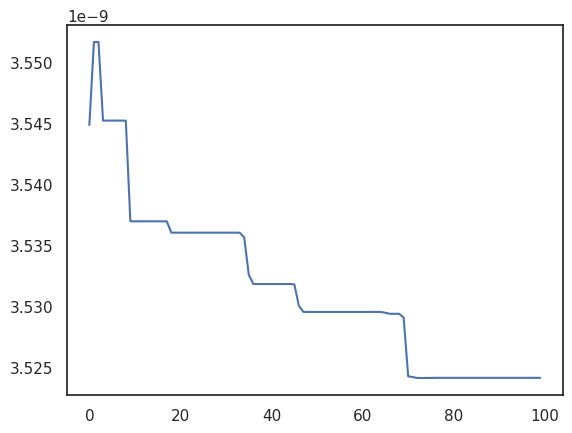

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 4.056415904102888e-09, GW-cost: 3.727946676424919e-39, Total cost: 3.6507743136925994e-09
Final Wasserstein cost: 4.016640469138533e-09, GW-cost: 3.727946664449363e-39, Total cost: 3.61497642222468e-09


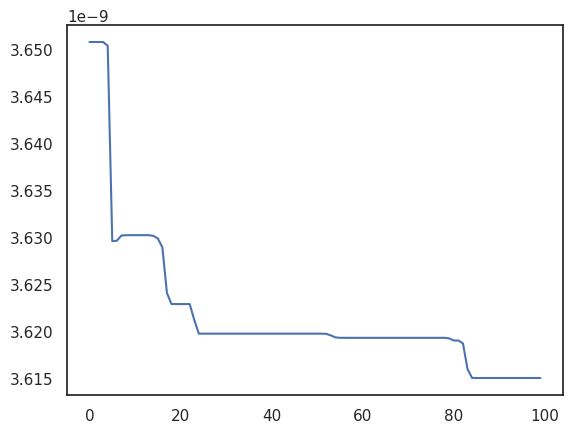

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.964084608195524e-09, GW-cost: 1.639475590435045e-50, Total cost: 2.667676147375972e-09
Final Wasserstein cost: 2.7519422681861177e-09, GW-cost: 1.6394755904382672e-50, Total cost: 2.476748041367506e-09


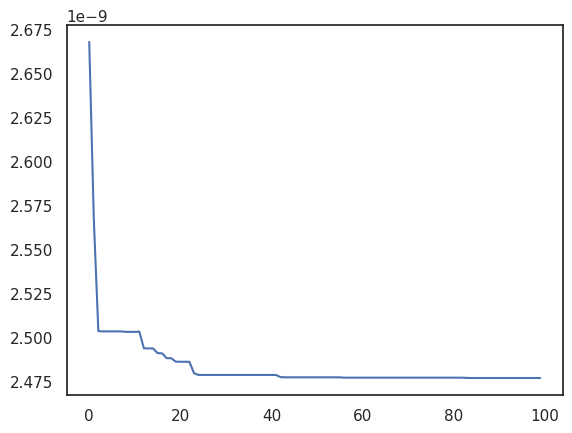

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.209539318289923e-09, GW-cost: 8.927671203345073e-73, Total cost: 2.8885853864609307e-09
Final Wasserstein cost: 3.1335261140371657e-09, GW-cost: 9.089543851329704e-73, Total cost: 2.820173502633449e-09


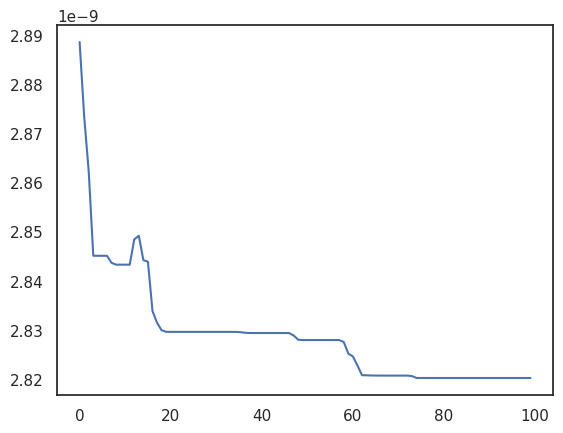

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.2593696733875425e-09, GW-cost: 8.366827596648373e-74, Total cost: 2.9334327060487883e-09
Final Wasserstein cost: 3.1125917737473165e-09, GW-cost: 8.366827591380735e-74, Total cost: 2.801332596372585e-09


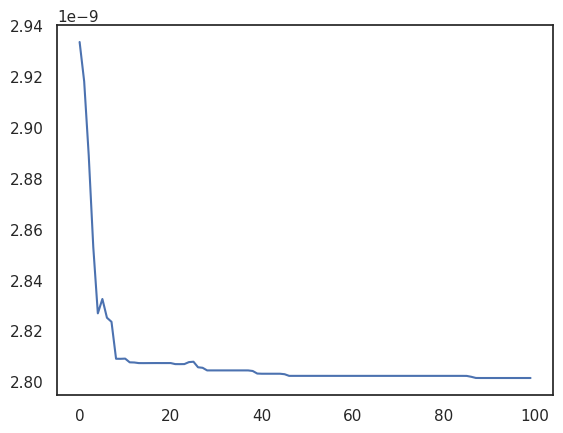

CPU times: user 1min 9s, sys: 1.16 s, total: 1min 10s
Wall time: 1min 9s


In [94]:
%%time
Q_annot = Qs_gt_tensor

importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=100, min_iter=100, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args=None)

WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)
T_gammas = WDM2.T_gammas

In [95]:
for i,Q in enumerate(WDM2.Q_gammas):
    np.save(filehandle_save + f'ann_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM2.T_gammas):
    np.save(filehandle_save + f'ann_T{i}{i+1}.npy', T.cpu().numpy())

# Analysis part 1: entropy of transitions

In [96]:
Ts_ann = T_gammas
Ts_pred = Ts_pred

## entropy functions

In [97]:
from scipy.stats import entropy

In [100]:
for i, T in enumerate(Ts_ann):
    ent = entropy(T.cpu().numpy().flatten())
    print(f'The entropy of anno transitions from {i} to {i+1} is {ent}')

The entropy of anno transitions from 0 to 1 is 1.846358322829089
The entropy of anno transitions from 1 to 2 is 2.3374279424913635
The entropy of anno transitions from 2 to 3 is 2.391704806693634
The entropy of anno transitions from 3 to 4 is 2.6801245405317777
The entropy of anno transitions from 4 to 5 is 2.941565911881601


In [103]:
for i, T in enumerate(Ts_pred):
    ent = entropy(T.flatten())
    print(f'The entropy of pred transitions from {i} to {i+1} is {ent}')

The entropy of pred transitions from 0 to 1 is 2.0868449271782996
The entropy of pred transitions from 1 to 2 is 2.126897581286154
The entropy of pred transitions from 2 to 3 is 2.588462254123299
The entropy of pred transitions from 3 to 4 is 2.9174855420012653
The entropy of pred transitions from 4 to 5 is 3.213742825485035


In [116]:
def compute_column_entropy(gamma):
    # Ensure gamma is a NumPy array
    gamma = np.array(gamma)
    g = np.sum(gamma, axis=0)
    gamma = gamma @ np.diag(1 / g)
    # Avoid log(0) by adding a small epsilon where gamma is zero
    epsilon = 1e-12
    gamma_nonzero = gamma + (gamma == 0) * epsilon
    col_entropy_avg = 0
    for i in range(gamma.shape[1]):
        col_entropy_avg += -np.sum(gamma[:,i] * np.log(gamma_nonzero[:,i]))
    return col_entropy_avg

In [117]:
for i, T in enumerate(Ts_ann):
    ent = compute_column_entropy(T.cpu().numpy())
    print(f'The column entropy of anno transitions from {i} to {i+1} is {ent}')

The column entropy of anno transitions from 0 to 1 is 0.9351802356912553
The column entropy of anno transitions from 1 to 2 is 2.91687885373632
The column entropy of anno transitions from 2 to 3 is 2.404816791394481
The column entropy of anno transitions from 3 to 4 is 3.9742524353777284
The column entropy of anno transitions from 4 to 5 is 5.34671753485626


In [118]:
for i, T in enumerate(Ts_pred):
    ent = compute_column_entropy(T)
    print(f'The column entropy of pred transitions from {i} to {i+1} is {ent}')

The column entropy of pred transitions from 0 to 1 is 1.0935468849542118
The column entropy of pred transitions from 1 to 2 is 1.1610568560165213
The column entropy of pred transitions from 2 to 3 is 2.5307983713778945
The column entropy of pred transitions from 3 to 4 is 4.017509193199231
The column entropy of pred transitions from 4 to 5 is 5.535256309212392


# Analysis part 2: DE analysis

## load output of `WDM`

In [ ]:
wdm_Qs = []
wdm_Ts = []


wdm_Q0 = np.load(filehandle_save + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_save + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_save + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_save + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_save + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_save+ 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_save + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_save + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_save + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_save + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_save + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_save + 'ann_T0.npy')
ann_T1 = np.load(filehandle_save + 'ann_T1.npy')

### lists of these for the three cases

Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]

Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

Qs_wdm = [wdm_Q0, wdm_Q1, wdm_Q2]
Ts_wdm = [wdm_T0, wdm_T1]

## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [ ]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [ ]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

Ss = [S0, S1, S2]

## load labels

In [ ]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

ct_ann_0 = ct_labels[i]
ct_ann_1 = ct_labels[i+1]
ct_ann_2 = ct_labels[i+2]

# form cases
cell_type_labels_case_1 = [ct_ann_0, ct_ann_1, ct_ann_2]
cell_type_labels_case_2 = [ct_ann_0, None, ct_ann_2]
cell_type_labels_case_3 = [None, None, None]

## case 1: `ml` clustering,  annotations

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann,
                        Ts=Ts_ann,
                        cell_type_labels=cell_type_labels_case_1,
                        clustering_type='ml')

## case 2: `ml` clustering, annotations at $t_1, t_3$

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann_imp,
                        Ts=Ts_ann_imp,
                        cell_type_labels=cell_type_labels_case_2,
                        clustering_type='ml')

## case 3: fully unsupervised

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_wdm,
                        Ts=Ts_wdm,
                        cell_type_labels=cell_type_labels_case_3,
                        clustering_type='ml')

## focus on case 3, what does differential expression reveal about how these clusters compare to the annotations?

In [ ]:
pred_clustering_list = clustering.max_likelihood_clustering(Qs_wdm)
gt_clustering_list = clustering.max_likelihood_clustering(Qs_gt[2:5])

In [ ]:
pred_clustering_0 = pred_clustering_list[0]
pred_clustering_1 = pred_clustering_list[1]
pred_clustering_2 = pred_clustering_list[2]

## differential expression at 10hpf:

In [ ]:
_adata0 = adatas[2].copy()

_adata0.obs['diff_map_cluster'] = pred_clustering_0
_adata0.obs['diff_map_cluster'] = _adata0.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata0)
sc.pp.log1p(_adata0)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata0, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata0, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 10hpf

## differential expression at 12hpf:

In [ ]:
_adata1 = adatas[3].copy()

_adata1.obs['diff_map_cluster'] = pred_clustering_1
_adata1.obs['diff_map_cluster'] = _adata1.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata1)
sc.pp.log1p(_adata1)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata1, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata1, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 12hpf

## differential expression at 18hpf:

In [ ]:
_adata2 = adatas[4].copy()

_adata2.obs['diff_map_cluster'] = pred_clustering_2
_adata2.obs['diff_map_cluster'] = _adata2.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata2)
sc.pp.log1p(_adata2)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata2, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata2, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 18hpf